# Time Series Analysis with TDA
First, import the usual libraries

In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
#%matplotlib widget

Now we load the data.
We have five machines, for each of which we have time series for working well and for malfunctioning.
This way we get 10 numpy arrays in total.

In [2]:
datapath =".\\data\\timeseries\\good_new"
filelist = os.listdir(datapath)
print(sorted(filelist))
good_time_series = [np.array(pd.read_csv(os.path.join(datapath,f), header=None)[0]) for f in sorted(filelist)]
datapath =".\\data\\timeseries\\bad_new"
filelist = os.listdir(datapath)
print(sorted(filelist))
bad_time_series = [np.array(pd.read_csv(os.path.join(datapath,f), header=None)[0]) for f in sorted(filelist)]

print(good_time_series[0])

['sig1_good.txt', 'sig2_good.txt', 'sig3_good.txt', 'sig4_good.txt', 'sig5_good.txt']
['sig1_bad.txt', 'sig2_bad.txt', 'sig3_bad.txt', 'sig4_bad.txt', 'sig5_bad.txt']
[-0.11156466  0.01043311  0.30969176 ...  0.44117724  0.98839737
 -2.1306849 ]


Let us plot the time series

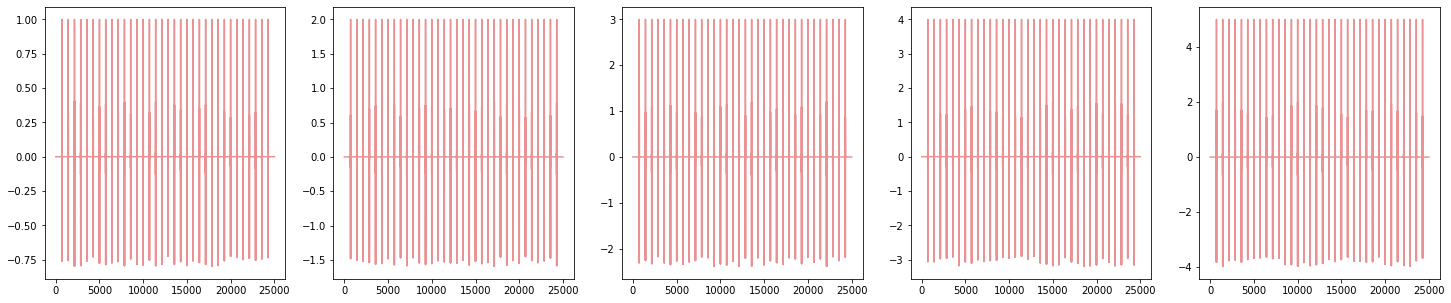

In [3]:
f,axes = plt.subplots(1,len(good_time_series), figsize = (25,5))
for i in range(0,len(good_time_series)):
    #axes[i].plot(np.array(range(len(good_time_series[i]))),good_time_series[i], alpha = 1, c="tab:green")
    #axes[i].plot(np.array(range(len(bad_time_series[i]))),bad_time_series[i], alpha=0.5, c="tab:red")
    axes[i].plot(np.array(range(len(bad_time_series[i]))),bad_time_series[i]-good_time_series[i], alpha=0.5, c="tab:red")
plt.show()

Now we use time delay embedding, mapping a time series valued in $\mathbb{R}$ to a point cloud in $\mathbb{R}^4$.
The parameters are determined by trial and error.
Concretely, using $dim =4, delay = 5, skip = 6$, we map the sequence
$$(x_1, x_2, x_3, x_4, x_5, x_6, \ldots)\mapsto ((x_1, x_6, x_{11}, x_{16}), (x_7,x_{12}, x_{17},x_{22}),(x_{13},x_{18},x_{23},x_{28})).$$

In [80]:
#dim * delay should roughly equal len(time_series)/numer_of_periods
dim = 500
delay = 50
skip = 1
print(dim*delay)
print(len(good_time_series[0]/34))

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
good_point_clouds = tde.transform(good_time_series)
bad_point_clouds = tde.transform(bad_time_series)
diff_point_clouds = tde.transform(np.array(bad_time_series) - np.array(good_time_series))

print(np.array(good_point_clouds).shape)
print(good_point_clouds[0])

25000
25000
(5, 50, 500)
[[-0.11156466 -2.3887457  -0.58963767 ...  0.01834991  0.35357411
   0.11709365]
 [ 0.01043311 -0.33041054 -0.67426825 ...  2.4216125  -1.2183272
  -1.0915369 ]
 [ 0.30969176 -2.3628401  -0.83892922 ...  2.2902571   0.62897243
   1.5387082 ]
 ...
 [ 1.2319359   2.0975232   0.10919947 ...  0.20948666 -0.32284749
   0.44117724]
 [-0.08308101  0.37197167 -2.3198832  ...  1.5586051  -0.08408006
   0.98839737]
 [ 0.7121579  -0.13972879  1.2726395  ... -0.89124321  0.29055957
  -2.1306849 ]]


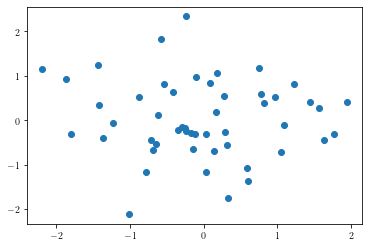

In [81]:
f,ax = plt.subplots()
#ax.scatter(good_point_clouds[4][:,0],good_point_clouds[4][:,1])
ax.scatter(bad_point_clouds[4][:,0],bad_point_clouds[4][:,1])

plt.show()

For each pointcloud, we compute persistent homology in dimension 1 using the alpha filtration.

In [82]:
good_pds = []

for pc in good_point_clouds:
    ac = gd.RipsComplex(pc)
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    good_pds.append(st.persistence_intervals_in_dimension(1))

bad_pds = []

for pc in bad_point_clouds:
    ac = gd.RipsComplex(pc)
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    bad_pds.append(st.persistence_intervals_in_dimension(1))

In [83]:
st.persistence_intervals_in_dimension(0)[:-1]

array([[ 0.        , 30.13017846],
       [ 0.        , 30.21414073],
       [ 0.        , 30.28585435],
       [ 0.        , 30.5377106 ],
       [ 0.        , 30.90359005],
       [ 0.        , 30.97975176],
       [ 0.        , 31.0941848 ],
       [ 0.        , 31.15230622],
       [ 0.        , 31.24116406],
       [ 0.        , 31.29002196],
       [ 0.        , 31.36147269],
       [ 0.        , 31.44277998],
       [ 0.        , 31.48437502],
       [ 0.        , 31.48610477],
       [ 0.        , 31.5804303 ],
       [ 0.        , 31.60707952],
       [ 0.        , 31.6280952 ],
       [ 0.        , 31.64486692],
       [ 0.        , 31.66469039],
       [ 0.        , 31.69102015],
       [ 0.        , 31.70334832],
       [ 0.        , 31.7384356 ],
       [ 0.        , 31.7631667 ],
       [ 0.        , 31.78259897],
       [ 0.        , 31.78989599],
       [ 0.        , 31.79818157],
       [ 0.        , 31.88347638],
       [ 0.        , 31.88617892],
       [ 0.        ,

In [84]:
good_pds[0].shape

(32, 2)

Now we plot the persistence diagrams.
The five pictures correspond to the five machines.
In each subfigure, the red diagram represents the well-working machine, whereas the green diagram represents the malfunctioning machine.

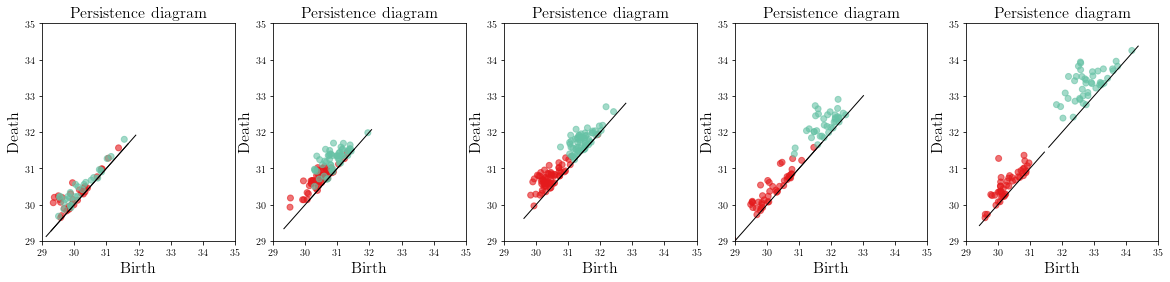

In [107]:
f,axes = plt.subplots(1,len(good_pds), figsize = (20,4))
for i in range(0,len(good_pds)):
    
    gd.plot_persistence_diagram(good_pds[i], axes=axes[i], greyblock=False)
    gd.plot_persistence_diagram(bad_pds[i], axes=axes[i],colormap=cm.Set2.colors, greyblock=False)
    #gd.plot_persistence_diagram([good_pds[i], bad_pds[i]], axes=axes[i])
    axes[i].set_ylim((29,35))
    axes[i].set_xlim((29,35))
plt.show()

In [91]:
good_pds[-1]

array([[29.59659744, 29.6358891 ],
       [29.66736158, 29.73048191],
       [29.60504775, 29.73048191],
       [29.93512591, 29.98097189],
       [30.06310349, 30.07635321],
       [30.01010587, 30.07635321],
       [30.11263033, 30.2080256 ],
       [30.1959657 , 30.22541076],
       [30.1449508 , 30.22541076],
       [30.16426269, 30.24708718],
       [29.81364216, 30.24708718],
       [29.9018101 , 30.25841128],
       [30.22000551, 30.27098021],
       [29.77590996, 30.27604612],
       [30.23919732, 30.28536824],
       [30.00456371, 30.33906239],
       [30.04810768, 30.35962794],
       [30.10035124, 30.35962794],
       [30.08202777, 30.36419696],
       [30.16522788, 30.44125551],
       [30.07667732, 30.5086337 ],
       [30.33768858, 30.5086337 ],
       [30.07814678, 30.5086337 ],
       [30.26588047, 30.53183579],
       [30.082497  , 30.62374855],
       [30.28183319, 30.63942711],
       [30.45115855, 30.64563501],
       [30.54305654, 30.67678419],
       [30.33560633,

To do machine learning, we vectorize the diagrams to peristent images.
For illustration, we plot the PI corresponding to Machine 1 working well.

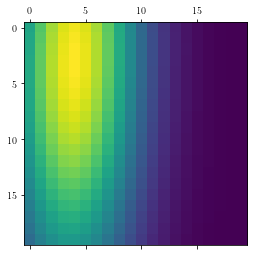

In [105]:
pi = PersistenceImage()
pi.fit(good_pds+bad_pds)
good_pis = pi.transform(good_pds)
bad_pis = pi.transform(bad_pds)
plt.matshow(good_pis[0].reshape(pi.resolution))

Next, we use MDS to visualize the data set in two dimensions.

In [87]:
pis = np.concatenate((good_pis,bad_pis))
mds = MDS(n_components=2)
emb =mds.fit_transform(pis)

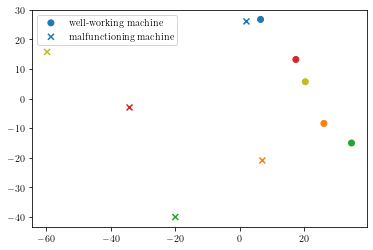

In [88]:
f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()

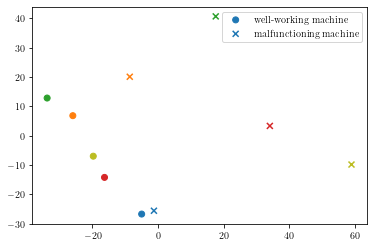

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb = pca.fit_transform(pis)

f,ax = plt.subplots()
colors = ["tab:blue","tab:orange", "tab:green", "tab:red","tab:olive"]
ax.scatter(emb[:5,0],emb[:5,1], marker = "o", c= colors, label="well-working machine")
ax.scatter(emb[5:,0],emb[5:,1], marker = "x", c=colors, label="malfunctioning machine")
ax.legend()
plt.show()

In [103]:
WD = gd.representations.WassersteinDistance(order=2, internal_p=2, n_jobs = -1)
dist_matrix = WD.fit_transform(good_pds+bad_pds)

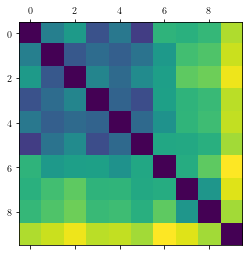

In [104]:
plt.matshow(dist_matrix)